In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import beta
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
sns.set()

# 1. Óbitos Diários

In [2]:
obitos_diarios = pd.read_csv('bitos-novos.csv')
casos_diarios = pd.read_csv('casos-novos.csv')
obitos_diarios['Data'] = pd.to_datetime(obitos_diarios['Data'], infer_datetime_format=True)
casos_diarios['Data'] = pd.to_datetime(casos_diarios['Data'], infer_datetime_format=True)

obitos_diarios_percent = pd.DataFrame(columns=['Data', 'Porcentagem'])
obitos_diarios_percent['Data'] = obitos_diarios['Data']
obitos_diarios_percent['Porcentagem'] = (obitos_diarios['#BR: Rio de Janeiro'] / casos_diarios['#BR: Rio de Janeiro'])

obitos_diarios_percent

,Data,Porcentagem
0,2020-03-05,0.000000
1,2020-03-06,0.000000
2,2020-03-08,0.000000
3,2020-03-12,0.000000
4,2020-03-15,0.000000
...,...,...
164,2020-08-25,0.063564
165,2020-08-26,0.052395
166,2020-08-27,0.063020
167,2020-08-29,0.041766


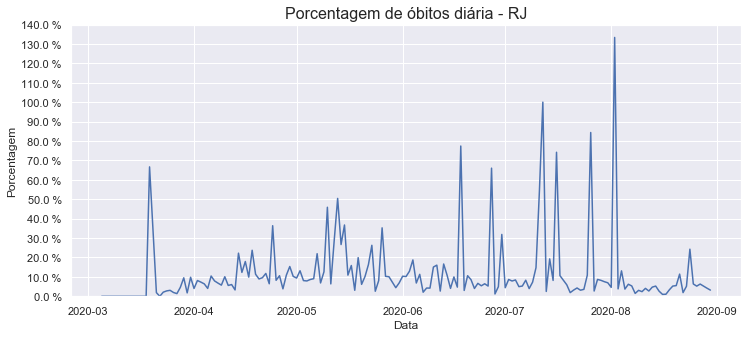

In [3]:
y_ticks = np.linspace(0, 1.4, 15)
y_ticklabels = [f'{(tick * 100):.1f} %' for tick in y_ticks]

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x='Data', y='Porcentagem', data=obitos_diarios_percent, ax=ax)
_ = ax.set_ylim([0, 1])
_ = ax.set_yticks(y_ticks)
_ = ax.set_yticklabels(y_ticklabels)
_ = ax.set_title('Porcentagem de óbitos diária - RJ', size=16)

## 1.1 Aproximando a Prior com MLE

In [4]:
mask_dados_prior = (obitos_diarios_percent['Data'] <= datetime(day=30, month=6, year=2020))
obitos_diarios_percent_prior = obitos_diarios_percent.loc[mask_dados_prior, 'Porcentagem'].to_frame()
obitos_diarios_percent_prior.shape

(110, 1)

In [5]:
obitos_diarios

,Data,#BR: Rio de Janeiro
0,2020-03-05,0
1,2020-03-06,0
2,2020-03-08,0
3,2020-03-12,0
4,2020-03-15,0
...,...,...
164,2020-08-25,168
165,2020-08-26,140
166,2020-08-27,159
167,2020-08-29,157


Para encontrar o MLE para uma distribuição Beta, é necessário que todos os dado sejam maior que 0 e menor que 1. Por isso, nos casos em que a porcentagem de óbitos diário é menor ou igual a 0 são substituídos por um valor muito próximo de 0 (1e-10).

In [6]:
mask = obitos_diarios_percent_prior['Porcentagem'] <= 0
obitos_diarios_percent_prior.loc[mask, 'Porcentagem'] = 1e-10

Checando se os valores máximo e mínimo estão agora entre 0 e 1

In [7]:
obitos_diarios_percent_prior.describe()

,Porcentagem
count,1.100000e+02
mean,1.181730e-01
std,1.357300e-01
min,1.000000e-10
25%,4.229492e-02
50%,8.183379e-02
75%,1.218139e-01
max,7.740113e-01


In [8]:
a_prior_inicial, b_prior_inicial, _, _ = beta.fit(obitos_diarios_percent_prior['Porcentagem'], 
                                                  floc=0, fscale=1)
a_prior_inicial, b_prior_inicial

(0.3479143266979827, 2.7082862131118626)

Para verificar a distribuição encontrada através do MLE, vamos comparar a distribuição beta encontrada com o histograma dos dados usados para estimar a prior.

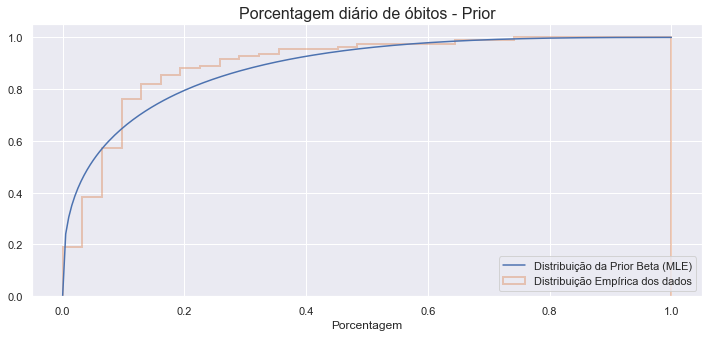

In [9]:
x = np.linspace(0, 1, 200)
y = beta.cdf(x, a_prior_inicial, b_prior_inicial)
bin_edges = np.histogram_bin_edges(obitos_diarios_percent_prior['Porcentagem'],
                                   bins='auto', range=(0.0, 1.0))

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x=x, y=y, label='Distribuição da Prior Beta (MLE)', ax=ax)
ax = sns.distplot(obitos_diarios_percent_prior['Porcentagem'], kde=False, 
                  norm_hist=True, bins=bin_edges, 
                  hist_kws={'cumulative':True, 'histtype': 'step', 'linewidth':2},
                  label='Distribuição Empírica dos dados', ax=ax)
_ = ax.set_title('Porcentagem diário de óbitos - Prior', size=16)
_ = plt.legend(loc='lower right')

## 1.2 Inferência Bayesiana

Primeiro precisamos calcular os valores dos parâmetros da likelihood binomial a
partir dos dados. Basta contar o número de sucessos e falhas em um dado conjunto de dados.

In [10]:
mask_obitos_diarios_likelihood = (obitos_diarios['Data'] > datetime(day=30, month=6, year=2020))
mask_casos_diarios_likelihood = (casos_diarios['Data'] > datetime(day=30, month=6, year=2020))
obitos_diarios_likelihood = obitos_diarios.loc[mask_obitos_diarios_likelihood, '#BR: Rio de Janeiro'].to_frame()
casos_diarios_likelihood = casos_diarios.loc[mask_casos_diarios_likelihood, '#BR: Rio de Janeiro'].to_frame()

Como a distribuição beta é prior conjugada da distribuição binomial, a posterior também será uma distribuição beta.

* **$Prior \sim Beta(a, b)$**

$$f(\theta) = c_{1}\theta^{(a-1)}(1-\theta)^{(b-1)} d\theta$$

* **$Likelihood \sim Binomial(n+m,\theta)$**

$$f(D|\theta) = c_{2}\theta^n(1-\theta)^m$$

Em que:

n: número de sucessos

m: número de falhas

* **$Posterior \sim Beta(a+n, b+m)$**

$$f(\theta|D) = c_{3}\theta^{(a+n-1)}(1-\theta)^{(b+m-1)} d\theta$$

$$c_{3} = \frac{(a+n+b+m-1)!}{(a+n-1)!(b+m-1)!}$$

In [11]:
def calcular_beta_posterior(a_prior, b_prior, n_likelihood, m_likelihood):
    """
    Realiza a atualização bayesiana a partir de uma prior que segue uma distribuição
    Beta e uma likelihood que segue uma distribuição binomial.
    
    Parameters:
    a_prior: Parâmetro a da prior beta.
    b_prior: Parâmetro b da prior beta.
    n_likelihood: Parâmetro n (número de sucessos) da likelihood Binomial.
    m_likelihood: Parâmetro n (número de falhas) da likelihood Binomial.

    Returns:
    a_posterior: Parâmetro a da posterior beta
    b_posterior: Parâmetro b da posterior beta
    """
    a_posterior = a_prior + n_likelihood
    b_posterior = b_prior + m_likelihood
    return a_posterior, b_posterior

likelihood_data = zip(obitos_diarios_likelihood['#BR: Rio de Janeiro'], casos_diarios_likelihood['#BR: Rio de Janeiro'])
a_prior = a_prior_inicial
b_prior = b_prior_inicial
for n_obitos, n_casos in likelihood_data:
    # Parametros da Likelihood
    n_sucessos = n_obitos
    m_falhas = n_casos - n_obitos
    
    # Calculo da posterior
    a_post, b_post = calcular_beta_posterior(a_prior, b_prior, n_sucessos, m_falhas)
    
    # Prior se torna a ultima posterior
    a_prior = a_post
    b_prior = b_post

a_post, b_post

(5947.347914326698, 104746.7082862131)

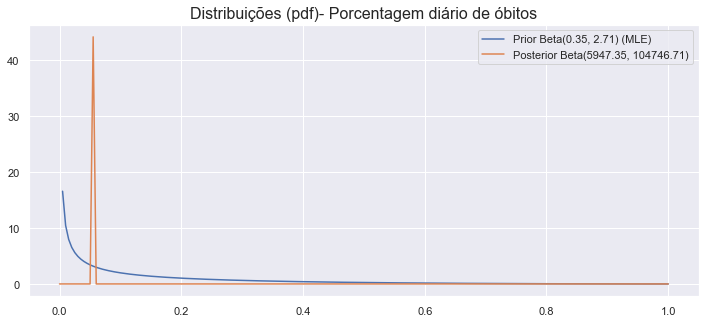

In [12]:
x = np.linspace(0, 1, 200)
prior = beta.pdf(x, a_prior_inicial, b_prior_inicial)
post = beta.pdf(x, a_post, b_post)

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x=x, y=prior, label=f'Prior Beta({a_prior_inicial:.2f}, {b_prior_inicial:.2f}) (MLE)', ax=ax)
ax = sns.lineplot(x=x, y=post, label=f'Posterior Beta({a_post:.2f}, {b_post:.2f})', ax=ax)
_ = ax.set_title('Distribuições (pdf)- Porcentagem diário de óbitos', size=16)
_ = plt.legend()
prior = ss.beta(a=1, b=4)

Vamos comparar a distribuição da Posterior e a distribuição empírica dos dados.

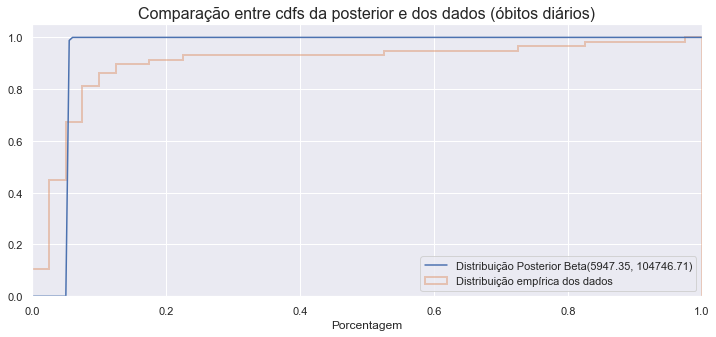

In [13]:
obitos_diarios_percent_likelihood = obitos_diarios_percent[obitos_diarios_percent['Data'] > datetime(day=30, month=6, year=2020)]
x = np.linspace(0, 1, 200)
post = beta.cdf(x, a_post, b_post)
bin_edges = np.histogram_bin_edges(obitos_diarios_percent_likelihood['Porcentagem'],
                                   bins='fd', range=(0.0, 1.0))

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x=x, y=post, label=f'Distribuição Posterior Beta({a_post:.2f}, {b_post:.2f})', ax=ax)
ax = sns.distplot(obitos_diarios_percent_likelihood['Porcentagem'], kde=False, 
                  norm_hist=True, bins=bin_edges, 
                  hist_kws={'cumulative':True, 'histtype': 'step', 'linewidth':2},
                  label='Distribuição empírica dos dados', ax=ax)
_ = ax.set_title('Comparação entre cdfs da posterior e dos dados (óbitos diários)', size=16)
_ = ax.set_xlim([0, 1])
_ = plt.legend(loc='lower right')

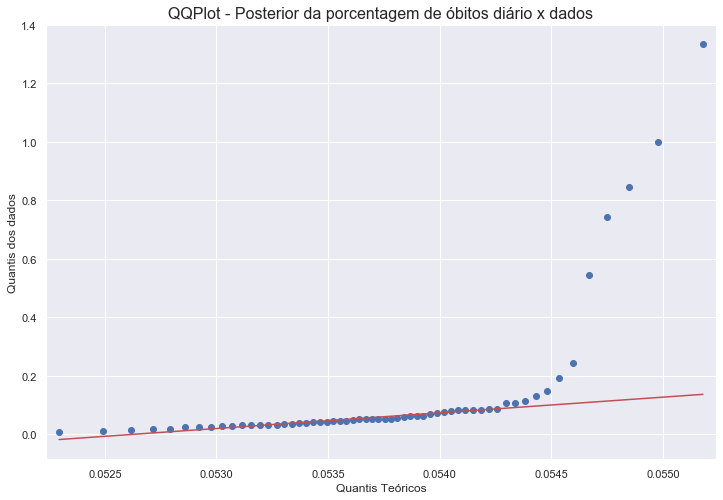

In [15]:
fig, ax = plt.subplots(figsize=(12,8)) 
pplot = sm.ProbPlot(obitos_diarios_percent_likelihood['Porcentagem'],
                    dist=ss.beta, fit=False, distargs=(a_post, b_post), a=0, loc=0, scale=1)
_ = pplot.qqplot(xlabel='Quantis Teóricos', ylabel='Quantis dos dados', line='q', ax=ax)
_ = ax.set_title('QQPlot - Posterior da porcentagem de óbitos diário x dados', size=16)

# 2. Óbitos acumulados

In [17]:
obitos_acumulados = pd.read_csv('bitos-acumulados-quantid.csv')
casos_acumulados = pd.read_csv('casos-acumulados-quantid.csv')
obitos_acumulados['dia'] = obitos_acumulados.index + 1
casos_acumulados['dia'] = casos_acumulados.index + 1

obitos_acumulados_percent = pd.DataFrame(columns=['dia', 'Porcentagem'])
obitos_acumulados_percent['dia'] = obitos_acumulados['dia']
obitos_acumulados_percent['Porcentagem'] = (obitos_acumulados['#BR: Rio de Janeiro'] / casos_acumulados['#BR: Rio de Janeiro'])

obitos_acumulados_percent

,dia,Porcentagem
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,0.000000
...,...,...
164,165,0.072709
165,166,0.072459
166,167,0.072350
167,168,0.071834


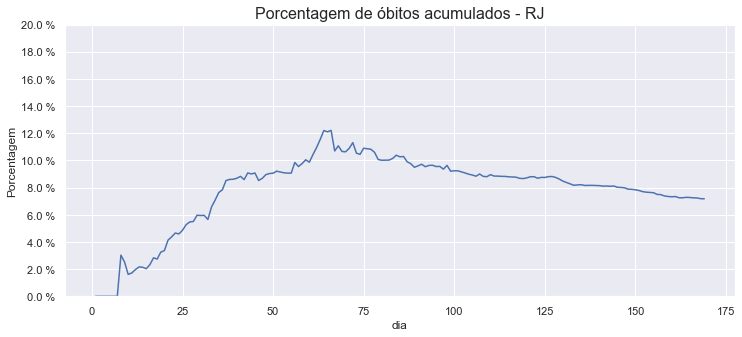

In [18]:
x_ticks = np.linspace(0, 0.2, 11)
x_ticklabels = [f'{(tick * 100):.1f} %' for tick in x_ticks]

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x='dia', y='Porcentagem', data=obitos_acumulados_percent, ax=ax)
_ = ax.set_ylim([0, 0.2])
_ = ax.set_yticks(x_ticks)
_ = ax.set_yticklabels(x_ticklabels)
_ = ax.set_title('Porcentagem de óbitos acumulados - RJ', size=16)

## 2.1 Aproximando a Prior com MLE

O dia 30/06/2020, no caso desse conjunto de dados, equivale ao dia 110. Logo, é preciso separar os 110 primeiros dias do conjunto de dados para estimar a prior.

In [19]:
mask_dados_prior = (obitos_acumulados_percent['dia'] <= 110)
obitos_acumulados_percent_prior = obitos_acumulados_percent.loc[mask_dados_prior, 'Porcentagem'].to_frame()
obitos_acumulados_percent_prior.shape

(110, 1)

Novamente, nos casos em que a porcentagem de óbitos acumulados é igual a 0 são substituídos por um valor muito próximo de 0 (1e-10).

In [20]:
mask = obitos_acumulados_percent_prior['Porcentagem'] == 0
obitos_acumulados_percent_prior.loc[mask, 'Porcentagem'] = 1e-10

Checando se os valores máximo e mínimo estão agora entre 0 e 1

In [21]:
obitos_acumulados_percent_prior.describe()

,Porcentagem
count,1.100000e+02
mean,7.678843e-02
std,3.361039e-02
min,1.000000e-10
25%,5.541666e-02
50%,9.061320e-02
75%,9.890758e-02
max,1.220883e-01


In [22]:
a_prior_inicial, b_prior_inicial, _, _ = beta.fit(obitos_acumulados_percent_prior['Porcentagem'], fscale=1, floc=0)
a_prior_inicial, b_prior_inicial

(0.4783854952816147, 6.189893526878089)

Para verificar a distribuição encontrada através do MLE, vamos comparar a distribuição beta encontrada com o histograma dos dados usados para estimar a prior.

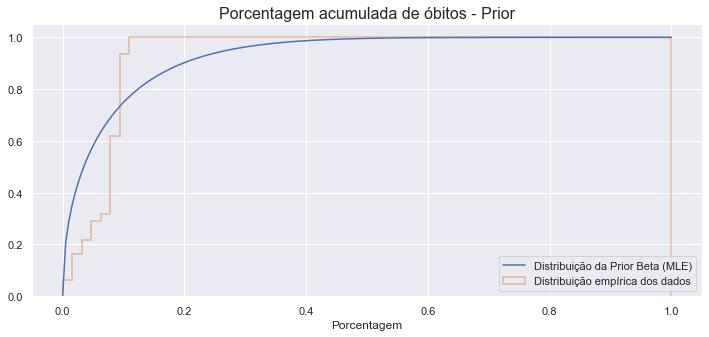

In [23]:
x = np.linspace(0, 1, 200)
y = beta.cdf(x, a_prior_inicial, b_prior_inicial)
bin_edges = np.histogram_bin_edges(obitos_acumulados_percent_prior['Porcentagem'],
                                   bins='auto', range=(0.0, 1.0))

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x=x, y=y, label='Distribuição da Prior Beta (MLE)', ax=ax)
ax = sns.distplot(obitos_acumulados_percent_prior['Porcentagem'], kde=False, 
                  norm_hist=True, bins=bin_edges,
                  hist_kws={'cumulative':True, 'histtype': 'step', 'linewidth':2},
                  label='Distribuição empírica dos dados', ax=ax)
_ = ax.set_title('Porcentagem acumulada de óbitos - Prior', size=16)
_ = plt.legend(loc='lower right')

## 2.2 Inferência Bayesiana

obitos_acumuladosPrimeiro precisamos calcular os valores dos parâmetros da likelihood binomial a
partir dos dados. Basta contar o número de sucessos e falhas em um dado conjunto de dados.

In [24]:
mask_obitos_acumulados_likelihood = (obitos_acumulados['dia'] > 110)
mask_casos_acumulados_likelihood = (casos_acumulados['dia'] > 110)
obitos_acumulados_likelihood = obitos_acumulados.loc[mask_obitos_acumulados_likelihood, '#BR: Rio de Janeiro'].to_frame()
casos_acumulados_likelihood = casos_acumulados.loc[mask_casos_acumulados_likelihood, '#BR: Rio de Janeiro'].to_frame()

Como a distribuição beta é prior conjugada da distribuição binomial, a posterior também será uma distribuição beta.

In [25]:
likelihood_data = zip(obitos_acumulados_likelihood['#BR: Rio de Janeiro'], casos_acumulados_likelihood['#BR: Rio de Janeiro'])
a_prior = a_prior_inicial
b_prior = b_prior_inicial
for n_obitos, n_casos in likelihood_data:
    # Parametros da Likelihood
    n_sucessos = n_obitos
    m_falhas = n_casos - n_obitos
    
    # Calculo da posterior
    a_post, b_post = calcular_beta_posterior(a_prior, b_prior, n_sucessos, m_falhas)
    
    # Prior se torna a ultima posterior
    a_prior = a_post
    b_prior = b_post

a_post, b_post

(779123.4783854953, 8974041.189893527)

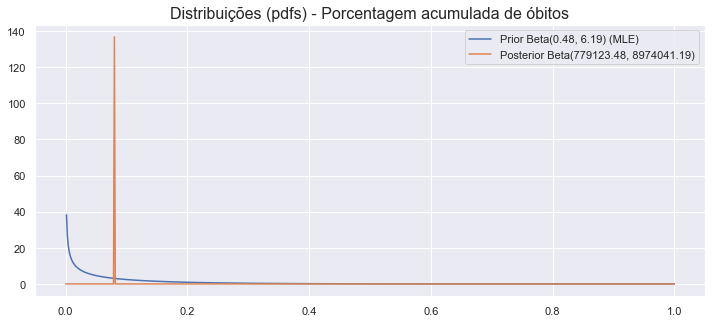

In [26]:
x = np.linspace(0, 1, 700)
prior = beta.pdf(x, a_prior_inicial, b_prior_inicial)
post = beta.pdf(x, a_post, b_post)

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x=x, y=prior, label=f'Prior Beta({a_prior_inicial:.2f}, {b_prior_inicial:.2f}) (MLE)', ax=ax)
ax = sns.lineplot(x=x, y=post, label=f'Posterior Beta({a_post:.2f}, {b_post:.2f})', ax=ax)
_ = ax.set_title('Distribuições (pdfs) - Porcentagem acumulada de óbitos', size=16)
_ = plt.legend()
prior = ss.beta(a=1, b=4)

Vamos comparar as distribuições da Posterior e da distribuição empírica dos dados.

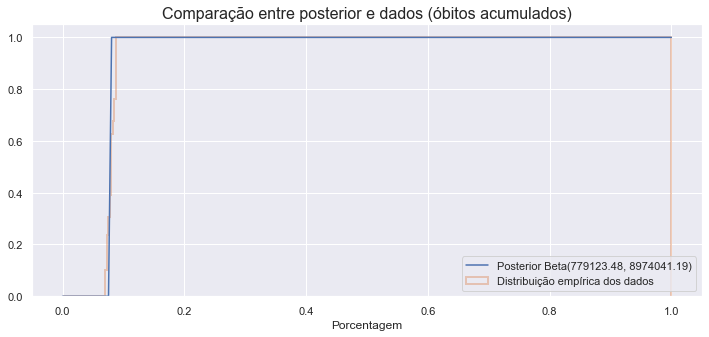

In [27]:
obitos_acumulados_percent_likelihood = obitos_acumulados_percent[obitos_acumulados_percent['dia'] > 110]
x = np.linspace(0, 1, 200)
post = beta.cdf(x, a_post, b_post)
bin_edges = np.histogram_bin_edges(obitos_acumulados_percent_likelihood['Porcentagem'],
                                   bins='auto', range=(0.0, 1.0))

fig, ax = plt.subplots(figsize=(12,5)) 
ax = sns.lineplot(x=x, y=post, label=f'Posterior Beta({a_post:.2f}, {b_post:.2f})', ax=ax)
ax = sns.distplot(obitos_acumulados_percent_likelihood['Porcentagem'], kde=False, 
                  norm_hist=True, bins=bin_edges, 
                  hist_kws={'cumulative':True, 'histtype': 'step', 'linewidth':2},
                  label='Distribuição empírica dos dados', ax=ax)
_ = ax.set_title('Comparação entre posterior e dados (óbitos acumulados)', size=16)
_ = plt.legend(loc='lower right')

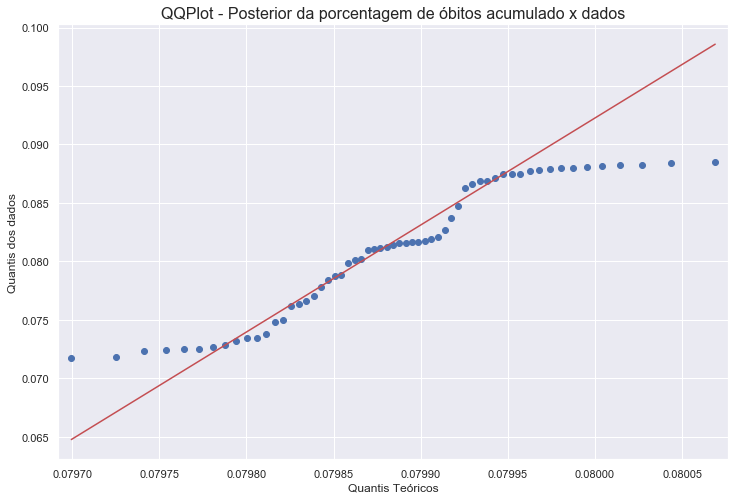

In [28]:
fig, ax = plt.subplots(figsize=(12,8)) 
pplot = sm.ProbPlot(obitos_acumulados_percent_likelihood['Porcentagem'],
                    dist=ss.beta, fit=False, distargs=(a_post, b_post), a=0, loc=0, scale=1)
_ = pplot.qqplot(xlabel='Quantis Teóricos', ylabel='Quantis dos dados', line='q', ax=ax)
_ = ax.set_title('QQPlot - Posterior da porcentagem de óbitos acumulado x dados', size=16)